<a href="https://colab.research.google.com/github/maxMitsuya/clustering_models/blob/main/clustering_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de análise das métricas de RFV

## Objetivo de negócio

- utilizar um modelo de Clustering para criar um sistema de agrupamento de perfis de clientes para um e-commerce.
- analisar o modelo mais eficiente, capaz de tornar as análises mais simplificadas para a empresa.

## Contexto

Uma empresa de e-commerce está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, devemos agrupar os clientes em clusters com base em seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como:

- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, vamos gerar insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.

## Data undestanding

Acesse os dados aqui: https://www.kaggle.com/datasets/carrie1/ecommerce-data

Os dados fornecidos possuem informações de transações de compras de uma loja de e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações.

### Setup

In [ ]:
%%capture
%pip install sidetable

In [ ]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale
from sklearn.cluster import estimate_bandwidth

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

from ipywidgets import interact

In [ ]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

### Etapa 1) EDA

In [ ]:
# Carregando os dados
df = pd.read_csv('data.csv', encoding = 'latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Descrição estatística das variáveis numéricas
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,462115.00000,462115.000000
mean,9.75856,4.670336
std,163.93112,99.251335
min,-74215.00000,-11062.060000
25%,1.00000,1.250000
50%,3.00000,2.080000
75%,11.00000,4.130000
max,74215.00000,38970.000000


In [ ]:
# Verificando distribuição dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462115 entries, 0 to 462114
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    462115 non-null  object 
 1   StockCode    462115 non-null  object 
 2   Description  460737 non-null  object 
 3   Quantity     462115 non-null  int64  
 4   InvoiceDate  462115 non-null  object 
 5   UnitPrice    462115 non-null  float64
 6   CustomerID   347829 non-null  float64
 7   Country      462115 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 28.2+ MB


In [ ]:
df[['Description','Country']].nunique()

,0
Description,4161
Country,39


<Axes: ylabel='Country'>

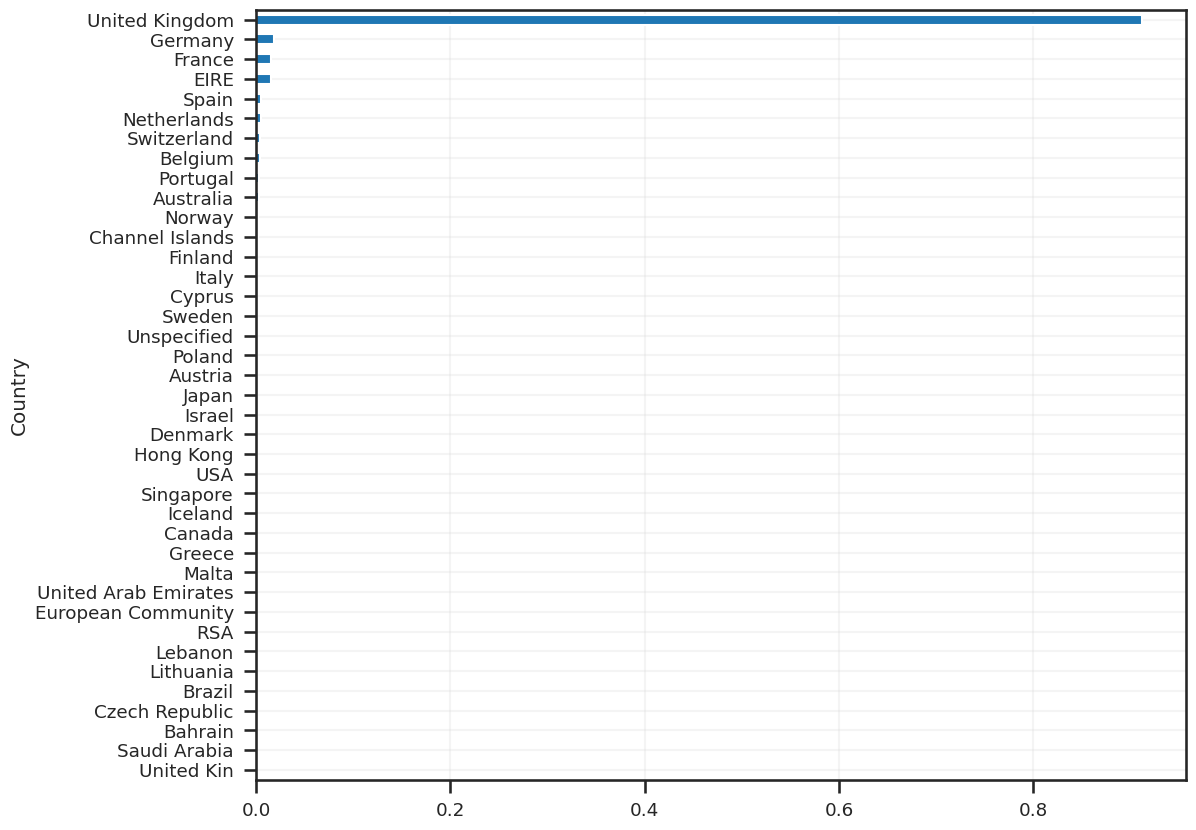

In [ ]:
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10))

In [ ]:
df.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,421171,91.139868,421171,91.139868
1,Germany,8357,1.808424,429528,92.948292
2,France,7323,1.584670,436851,94.532963
3,EIRE,7067,1.529273,443918,96.062236
4,Spain,2310,0.499876,446228,96.562111
5,Netherlands,2194,0.474774,448422,97.036885
6,Switzerland,1920,0.415481,450342,97.452366
7,Belgium,1847,0.399684,452189,97.852050
8,Portugal,1304,0.282181,453493,98.134231
9,Australia,1224,0.264869,454717,98.399100


In [ ]:
# Analisando dados faltantes
df.isna().sum().sort_values(ascending=False)

,0
CustomerID,114286
Description,1378
StockCode,0
InvoiceNo,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


In [ ]:
# Conferindo dados duplicados
df.duplicated().sum()

np.int64(4079)

<Axes: >

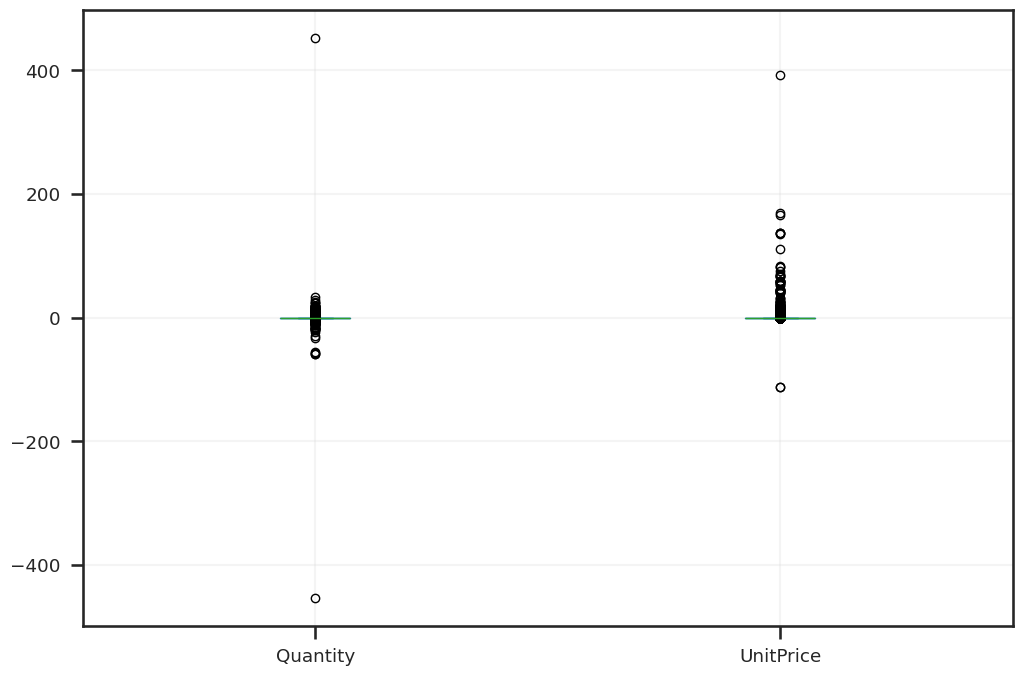

In [ ]:
# Verificando outliers
df[['Quantity', 'UnitPrice']].apply(scale).plot.box(figsize=(12,8))

Principais insigths
- Quantity e UnitPrice possuem valores negativos o que não faz sentido para essas variáveis;
- Quantity e UnitPrice possuem grande variação nos dados com presença de outliers;
- Coluna InvoiceNo possui tipo object o que indica que os valores devem ser códigos com números e letras;
- Maior parte dos dados de paises (Country) é representado apenas pelos 10 primeiros;
- Temos muitos dados faltantes nas colunas CustomerID e Description;
- Temos 5268 dados duplicados;
- Variável InvoiceNo está no formato errado.

### Etapa 2) Pré-processamento

In [ ]:
# Tratando dados nulos
# Verificando quantidade de nulos
df.stb.missing()

,missing,total,percent
CustomerID,114286,462115,24.731073
Description,1378,462115,0.298194
StockCode,0,462115,0.000000
InvoiceNo,0,462115,0.000000
Quantity,0,462115,0.000000
InvoiceDate,0,462115,0.000000
UnitPrice,0,462115,0.000000
Country,0,462115,0.000000


- Como a variável CustomerID é aquela que identifica o cliente, ela será necessária para a identificação dos clusters, portanto, como não possuimos os valores precisamos excluí-los do df.

In [ ]:
df.dropna(subset=['CustomerID'], inplace = True)

In [ ]:
#Verificando que não há mais dados nulos
df.stb.missing()

,missing,total,percent
InvoiceNo,0,347829,0.0
StockCode,0,347829,0.0
Description,0,347829,0.0
Quantity,0,347829,0.0
InvoiceDate,0,347829,0.0
UnitPrice,0,347829,0.0
CustomerID,0,347829,0.0
Country,0,347829,0.0


In [ ]:
# Ajustando tipos de dados
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = '%m/%d/%Y %H:%M')
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')

In [ ]:
df = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 347829 entries, 0 to 462114
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    347829 non-null  object        
 1   StockCode    347829 non-null  object        
 2   Description  347829 non-null  object        
 3   Quantity     347829 non-null  int64         
 4   InvoiceDate  347829 non-null  datetime64[ns]
 5   UnitPrice    347829 non-null  float64       
 6   CustomerID   347829 non-null  int64         
 7   Country      347829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 21.6+ MB


In [ ]:
# Verificando periodo dos dados
df.InvoiceDate.agg(['min', 'max'])

,InvoiceDate
min,2010-12-01 08:26:00
max,2011-11-13 12:29:00


Verificamos que conforme informado, o período dos dados vai 2010 à 2011

In [ ]:
# Tratando valores abaixo de 0 para colunas Quantity e UnitPrice
below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()

<Axes: >

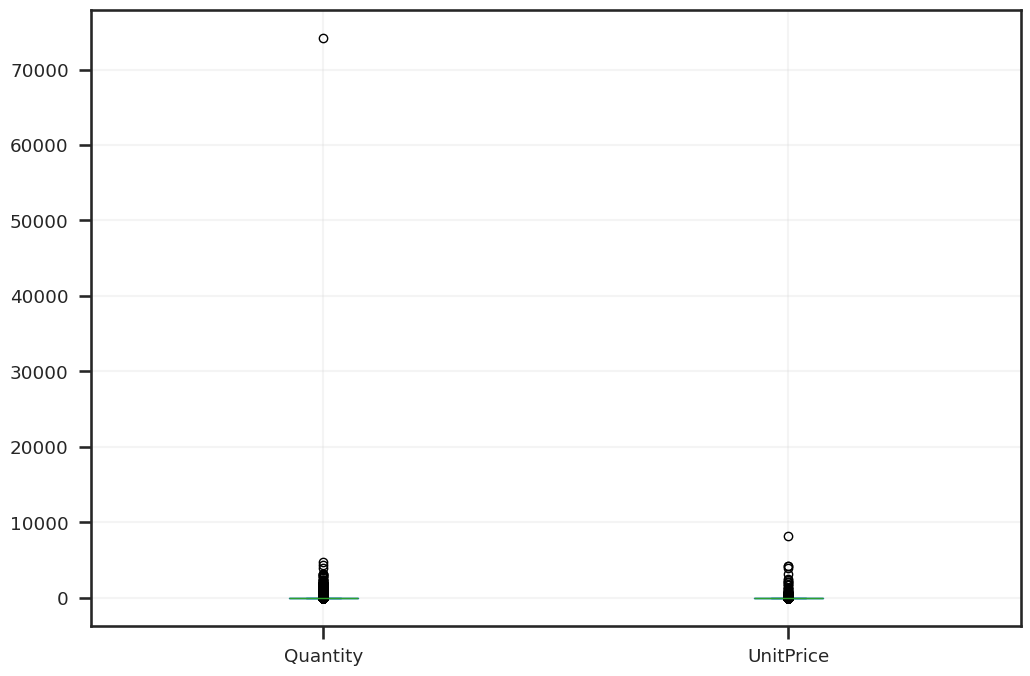

In [ ]:
df[['Quantity','UnitPrice']].plot.box()

In [ ]:
# Tratando outlier em Quantity
df.query('Quantity>10_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom


Verificamos que possuem duas compras com valores bem acima do normal, como o modelo de Kmeans considera a médias de valores, ter esses outlier vai impactar muito o modelo, por essa razão vamos removê-los.

<Axes: >

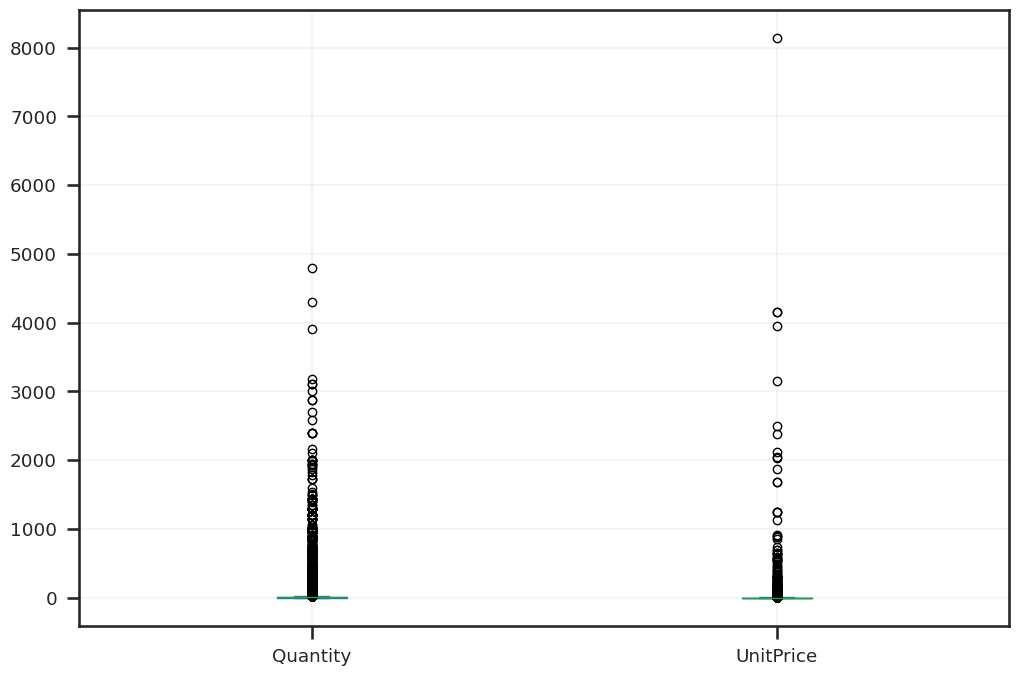

In [ ]:
df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

Verificamos que ainda possuimos muitos outliers, contudo, considerando uma base de dados de vendas de produtos diversos com categorias diferentes pode-se dizer que é esperado essa variação de valores. Ao final, vamos considerar os valores de Quantity abaixo de 10000 e de UnitPrice abaixo de 8000, removendo ao todo 3 observações consideradas além do normal.

In [ ]:
df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()

In [ ]:
# criando uma variável com preço total por cliente
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


Para realizar o clustering dos clientes com base em seu comportamente de compra, será necessário calcular o RFM de cada cliente. Dessa forma, as colunas necessárias serão:
- CustomerID;
- InvoiceDate;
- InvoiceNo;
- TotalPrice (Quantity * UnitPrice)

In [ ]:
# Calculando o RFM
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('TotalPrice', 'mean')
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347,61,6,23.889942
12348,97,4,57.975484
12350,332,1,19.670588
12352,58,8,29.482824
12353,226,1,22.250000
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,148,1,14.315714


<Axes: >

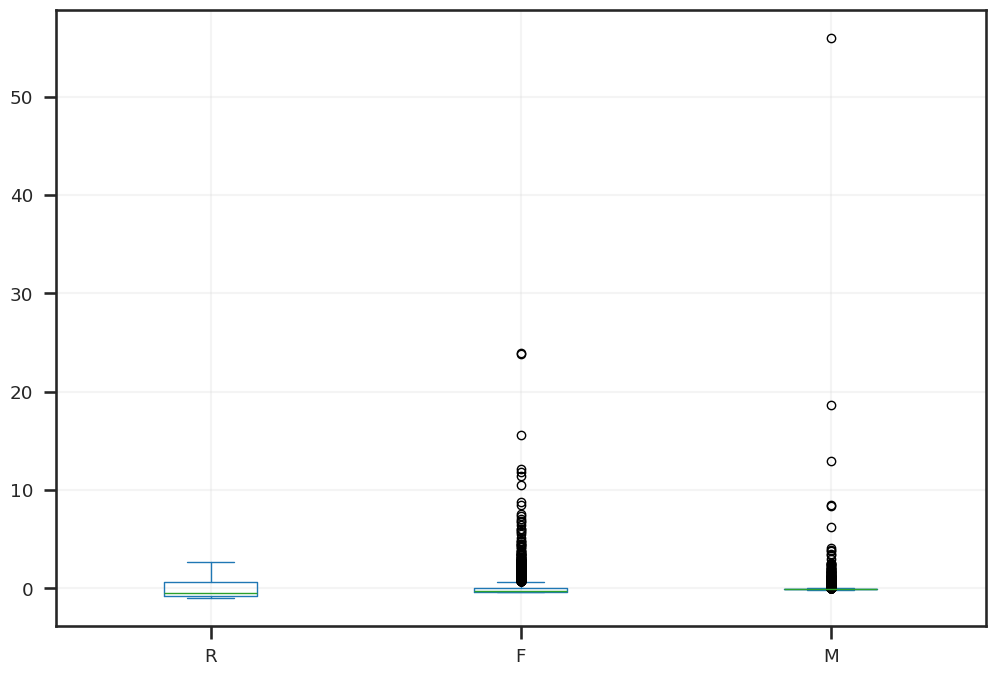

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
# Ajustando variáveis para tratamento de outliers
df_rfm = df_rfm.drop(15098) #Cliente com quantidade de compras inconsistente

In [ ]:
df_rfm.describe()

,R,F,M
count,4112.000000,4112.000000,4112.000000
mean,140.608220,3.913181,33.720920
std,96.189631,6.855601,115.311911
min,48.000000,1.000000,1.450000
25%,65.000000,1.000000,12.610833
50%,97.000000,2.000000,17.765320
75%,198.000000,4.000000,25.122000
max,395.000000,168.000000,4453.430000


In [ ]:
# Para tratamento de outliers vamos realizar uma abordagem na qual considera-se como valor máximo o quartil de até 95% dos dados
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()


,R,F,M
count,4112.000000,4112.000000,4112.000000
mean,138.935554,3.318580,23.821858
std,92.188170,3.079055,21.002213
min,48.000000,1.000000,1.450000
25%,65.000000,1.000000,12.610833
50%,97.000000,2.000000,17.765320
75%,198.000000,4.000000,25.122000
max,344.000000,12.000000,92.016842


In [ ]:
#Esse será o df utilizado nos modelos
df = df_rfm_clip.apply(scale)


## Modelagem

### Kmeans

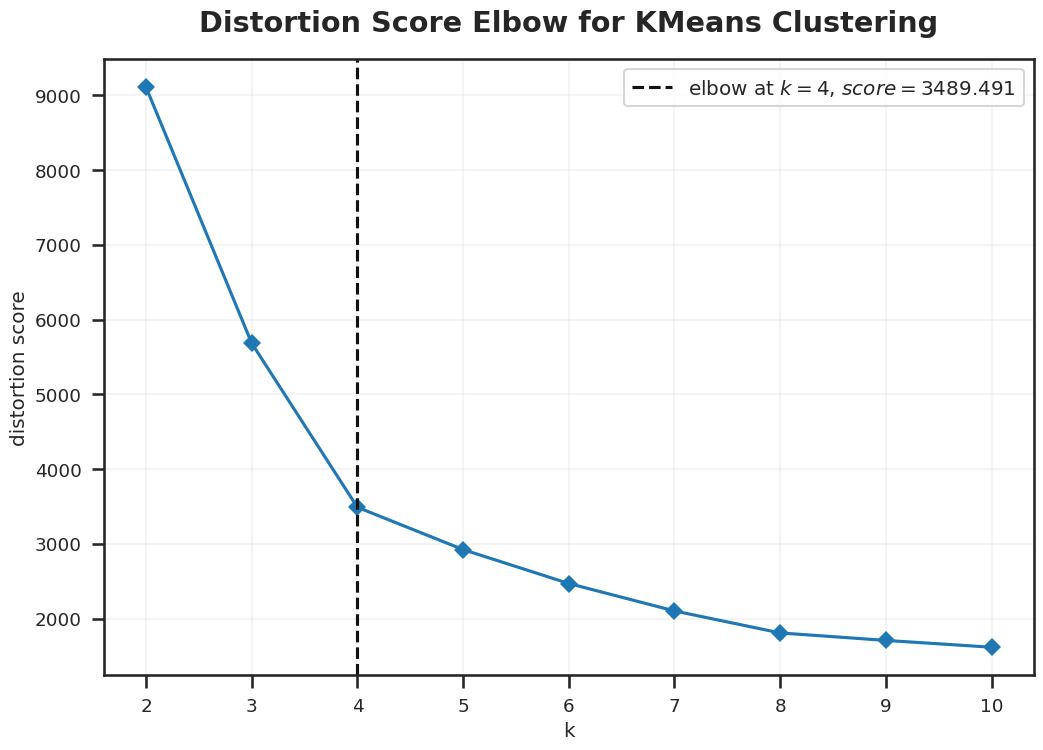

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [ ]:
kelbow_visualizer(KMeans(), df, k=10, timings=False)

In [ ]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8692.412510,0.375942,1.144377,1722.796568
3,5780.227301,0.420274,0.950088,2330.156637
4,3495.042074,0.469081,0.712044,3463.880926
5,2942.316859,0.475445,0.719466,3278.016824
6,2470.534803,0.394603,0.855029,3279.257597
7,2175.131881,0.398984,0.882163,3196.002657
8,1836.905282,0.391572,0.828634,3350.999808
9,1697.677220,0.355090,0.909649,3213.879370
10,1449.547617,0.363405,0.874687,3423.008614


Insights
- Pelo gráfico de Distorsion Score Elbow vemos que o número de K sugerido é 4, pelas métricas de silhouette (maior melhor), davies bouldin (menor melhor) e calinski (maior melhor), também chegamos a conclusão que o melhor valor de k é 4.

In [ ]:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df)

In [ ]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

### Hierarchical Clustering

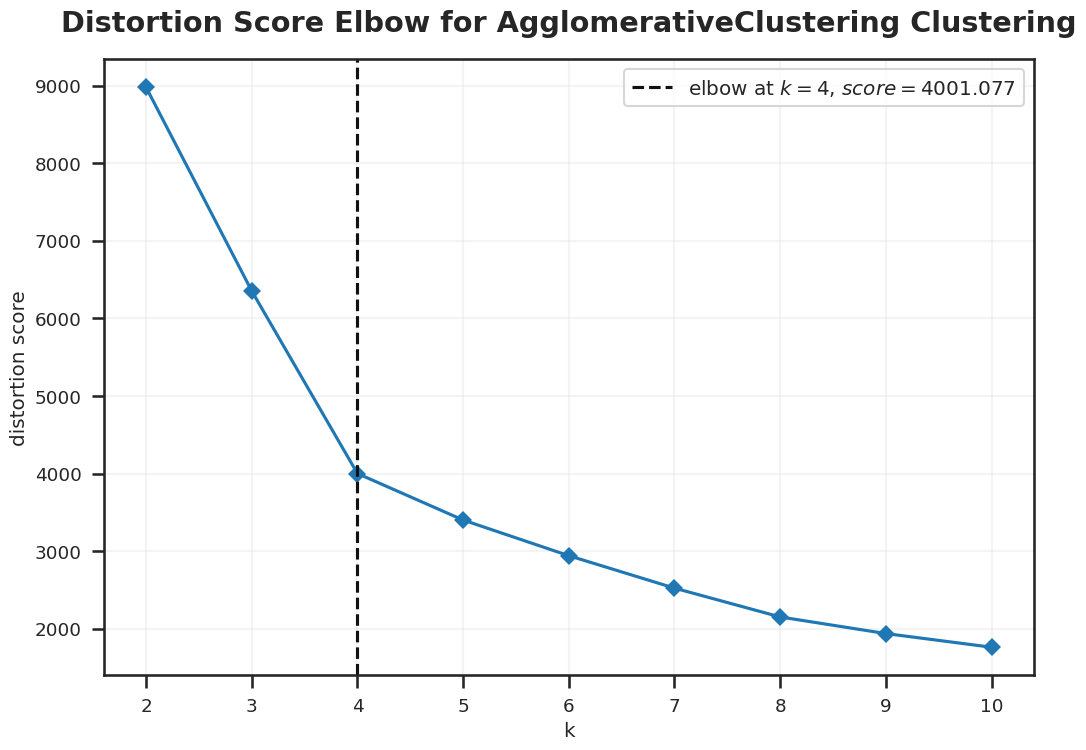

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
kelbow_visualizer(AgglomerativeClustering(), df, k=10, timings=False)

In [ ]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.320523,1.078865,1536.273970
3,0.393500,1.251772,1934.088719
4,0.441102,0.790951,2852.554443
5,0.341363,0.906007,2696.549754
6,0.346521,0.858450,2621.890142
7,0.351452,0.892799,2659.493074
8,0.330954,0.946928,2773.400985
9,0.337601,0.900184,2750.882793
10,0.298205,0.987496,2734.308919


In [ ]:
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df)

In [ ]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

### DBScan

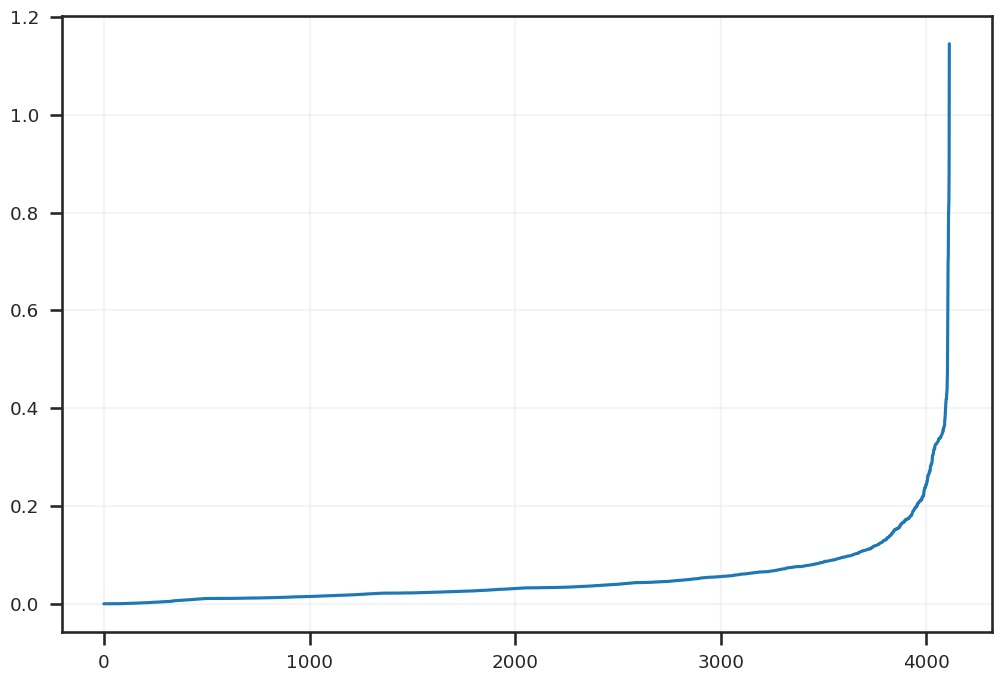

In [ ]:
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
from sklearn.neighbors import NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=2).fit(X)
distances, indices = nn_model.kneighbors(X)
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.show()

In [ ]:
# Pelo gráfico acima, vemos que um bom valor para eps seria de aproximadamente 0.2
model = DBSCAN(eps = 0.2, min_samples = 8)
dbscan_labels = model.fit_predict(df)
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=dbscan_labels.astype(str), template='plotly_dark')

### Meanshift

In [ ]:
# Estimating bandwidth
estimate_bandwidth(X)

np.float64(1.544576581264626)

In [ ]:
model = MeanShift(bandwidth = 1.544576581264626)
meanshift_labels = model.fit_predict(df)
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=meanshift_labels.astype(str), template='plotly_dark')

### Interpretação dos clusters

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)

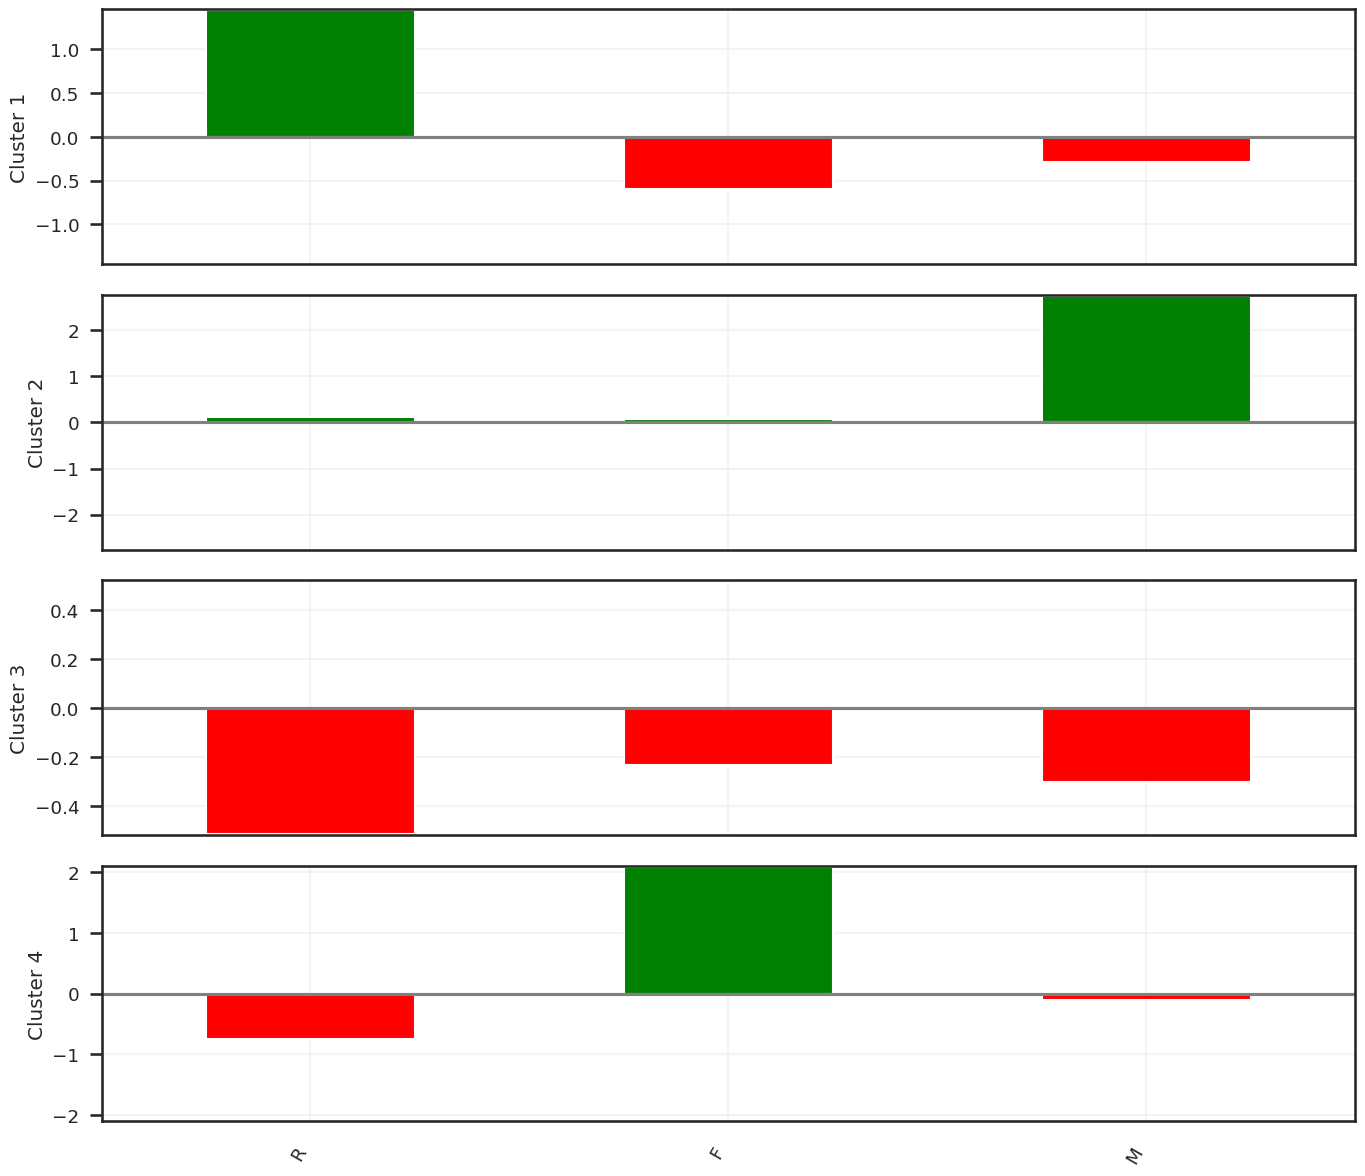

In [ ]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
R,271.601167,149.689189,91.343236,70.062738
F,1.472763,3.554054,2.606490,9.722433
M,17.772308,81.305090,17.436494,21.771137


Interpretação dos clusters
- Após testar os 4 modelos, vemos que o kmeans conseguiu gerar clusters mais bem definidos possibilitando uma maior compreensão/interpretação de cada agrupamento.
- Levando em consideração o gráfico gerado com kmeans vemos que temos 4 grupos distintos:
  - grupo com alto ticket médio, ou seja, compras de alto valor;
  - grupo com alta frequencia de pedido mas com baixo ticket médio e recência;
  - grupo com alta recência;
  - grupo com parâmetros neutros.


## Etapa 5) Interpretação dos resultados

Os resultados demonstram que:
- Grupo 0: pertecem os clientes com maior recência, ou seja, provalvemnte são clientes churn que não compram a muito tempo ou compraram apenas um produto;
- Grupo 1: pertecem os clientes que compram com baixa frequência, porém com alto valor, podem ser clientes que compram apenas em certas temporadas;
- Grupo 2: pertecem os clientes neutros, provavelmente são clientes que fazem compras casuais;
- Grupo 3: são os clientes mais frequentes em termos de pedido.

Com esses resultados a empresa pode realizar companhas de marketing visando cada segmento de clientes considerando qual meta ela vai querer atingir, por exemplo:
1. Grupo 0 (Clientes com Alta Recência, mas Provavelmente Churn)
- Problema identificado: Esses clientes podem ter abandonado a marca ou comprado apenas uma vez.

  - Ação de marketing: Campanhas de reativação (ex.: e-mails ou cupons de desconto com mensagens como "Sentimos sua falta!").

  - Ofertas personalizadas para incentivá-los a retornar.

  - Investigar motivos do abandono (pesquisas de satisfação).
2. Grupo 1 (Clientes com Baixa Frequência, mas Alto Valor por Compra)
- Característica: Compram esporadicamente, mas gastam muito (ex.: compras sazonais ou de alto ticket).

- Ação de marketing:

  - Campanhas sazonais ou de produtos premium (ex.: "Coleção exclusiva para você").

  - Oferecer benefícios como frete grátis ou atendimento VIP para fidelizá-los.

  - Evitar comunicação excessiva para não saturar.

3. Grupo 2 (Clientes Neutros – Compras Casuais)
- Característica: Não são fiéis nem grandes compradores, mas têm potencial.

- Ação de marketing:

  - Campanhas de upselling/cross-selling (ex.: "Quem comprou X também gostou de Y").

  - Descontos progressivos ou programas de fidelidade para aumentar a frequência.

  - Testar diferentes abordagens para identificar o que os converte em clientes mais ativos.

4. Grupo 3 (Clientes Mais Frequentes)
- Característica: São os clientes fiéis, que compram com maior frequência.

- Ação de marketing:

  - Recompensá-los com programas de fidelidade exclusivos (ex.: pontos acumulativos, brindes).

  - Oferecer antecipação de lançamentos ou acesso a vendas privadas.

  - Manter relacionamento contínuo (e-mails personalizados, agradecimentos).
